In [18]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

## Set up parameters, create isochrone grid

In [19]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F200W']
filters = ['m_jwst_F115W', 'm_jwst_F200W']
iso_dir = 'isochrones/'
metallicity = 0

# Select nbody6 simulation and snapshot, then convert to physical units and save as a cluster table which SPISEA can interface with

In [20]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma0.1/sfeff001_00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass               e                 log_a                age        
------------------- ---------- --------------------- ------------------- --------------------- ------------------ -------------------
 0.6824193596839905        0.0                    []  0.6824193596839905                   nan                nan  1.5194052457809448
0.04482797905802727        0.0                    [] 0.04482797905802727                   nan                nan  1.5194052457809448
0.24105285108089447        0.0                    [] 0.24105285108089447                   nan                nan  1.5194052457809448
0.10110508650541306        0.0                    [] 0.10110508650541306                   nan                nan  1.5194052457809448
                ...        ...                   ...                 ...                   ...                ...                 ...
0.04427308216691017        1.0 [0.01122098509222269] 0.0554940

# Read ages of stars, identify bracketing ages for isochrone generation
Also save mass of stars

In [21]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 5.160646094513871
Max log age = 6.181673621482367
Min level age = 144759.17338916156
Max level age = 1519405.2457809448


# Identify binary stars in cluster table, save mass of companion stars

Cluster table always lists binaries last, so finding the index of the first binary suffices

In [22]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
# print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
# print(compMasses)

# Generate isochrones using parameter and age arrays

In [23]:
increment = 0.5e6

if min(level_ages) < 0.5e6:
    start = 0.5e6
else:
    start = (min(level_ages) // increment) * increment

end = (max(level_ages) // increment) * increment + 2 * increment

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[5.69897    6.         6.17609126 6.30103   ]
[ 500000. 1000000. 1500000. 2000000.]


In [24]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


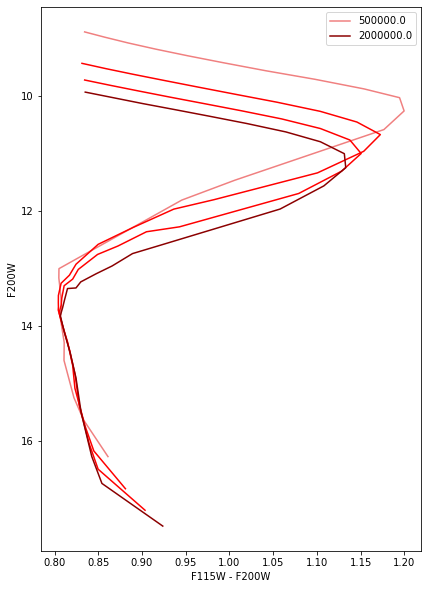

In [25]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
'''
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
'''
for i in range(len(log_age_arr)):
    if i == 0:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(log_age_arr) - 1:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F200W')
py.ylabel('F200W')
py.gca().invert_yaxis()
py.legend()

# Use generated SPISEA isochrones to find interpolated magnitudes using the age and mass of each star

Stars outside of the mass range of isochrones are thrown out and not included

In [26]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/')
import interpolator as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
# for i in range(len(stars)):
    # print(stars[i])

/scratch/wyz5rge/synthetic-hr/interpolator.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  w1 = (np.power(10, age_arr[a2]) / 1000000 - age) / (np.power(10, age_arr[a2]) / 1000000 - np.power(10, age_arr[a1]) / 1000000)
/scratch/wyz5rge/synthetic-hr/interpolator.py:99: RuntimeWarning: invalid value encountered in double_scalars
  s_lum = w1 * s1[1] + w2 * s2[1]
/scratch/wyz5rge/synthetic-hr/interpolator.py:100: RuntimeWarning: invalid value encountered in double_scalars
  s_teff = w1 * s1[2] + w2 * s2[2]
/scratch/wyz5rge/synthetic-hr/interpolator.py:101: RuntimeWarning: invalid value encountered in double_scalars
  s_logg = w1 * s1[3] + w2 * s2[3]
/scratch/wyz5rge/synthetic-hr/interpolator.py:102: RuntimeWarning: invalid value encountered in double_scalars
  s_filt1 = w1 * s1[4] + w2 * s2[4]
/scratch/wyz5rge/synthetic-hr/interpolator.py:103: RuntimeWarning: invalid value encountered in double_scalars
  s_filt2 = w1 * s1[5] + w2 * s2[5]


# Repeat interpolation on companion stars

Companion stars assumed to be the same age as primary star within system

In [27]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun


# Superimpose primary stars and companion stars against isochrones separately

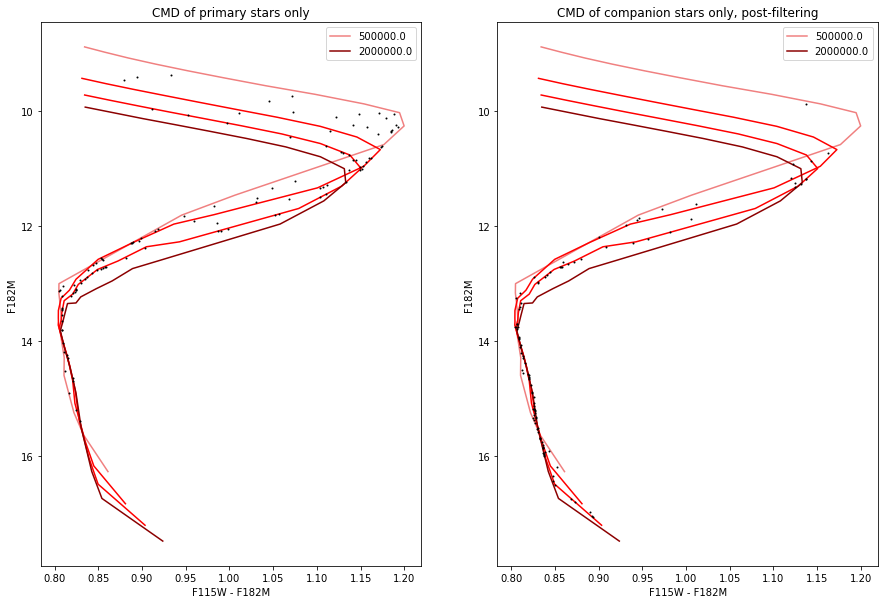

In [28]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)
for i in range(len(log_age_arr)):
    if i == 0:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(log_age_arr) - 1:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'red', label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD of primary stars only')
py.legend()

# plot companions
py.subplot(1, 2, 2)
for i in range(len(log_age_arr)):
    if i == 0:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(log_age_arr) - 1:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'red', label='')
        
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD of companion stars only, post-filtering')
py.legend()

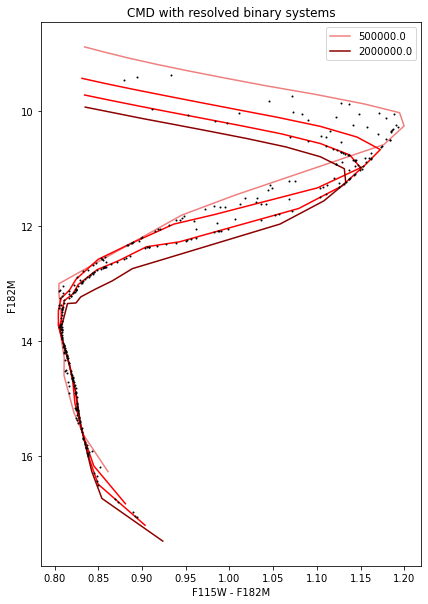

In [29]:
# plot CMD with resolved binary systems
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

py.subplot(1, 2, 1)

# plot isochrones
for i in range(len(log_age_arr)):
    if i == 0:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(log_age_arr) - 1:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'red', label='')
    
# plot primaries
for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot companions
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD with resolved binary systems')
py.legend()

In [35]:
# measure spread on CMD with resolved binaries

# Bounding box range 
color_min = 0.85
color_max = 1.05
mag_min = 11
mag_max = 13
color_step = 0.05

mags = []
bin_std_deviations = []

# Iterate over color bins
for color_index in np.arange(color_min, color_max, color_step):
    mag_bin = []
    count = 0
    
    # Iterate over stars within the current color bin
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        if color_index < stars[i][3] - stars[i][4] < color_index + color_step and mag_min < stars[i][4] < mag_max:
            mag_bin.append(stars[i][4])
            count += 1

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        if color_index < companions[i][3] - companions[i][4] < color_index + color_step and mag_min < companions[i][4] < mag_max:
            mag_bin.append(companions[i][4])
            count += 1

    bin_std = np.std(mag_bin)
    bin_std_deviations.append(bin_std)
    
    print(f"Standard deviation for color index {color_index:.2f} to {color_index + color_step:.2f}: {bin_std:.2f}")

# Compute the average standard deviation
average_std = np.mean(bin_std_deviations)
print("Average standard deviation:", average_std)

Standard deviation for color index 0.85 to 0.90: 0.18
Standard deviation for color index 0.90 to 0.95: 0.20
Standard deviation for color index 0.95 to 1.00: 0.20
Standard deviation for color index 1.00 to 1.05: 0.19
Standard deviation for color index 1.05 to 1.10: 0.25
Average standard deviation: 0.20369544400601206


# Convert binary stars into unresolved binaries
## Also compute flux ratios of stars and generate histogram
Magnitudes of primary and secondary are converted into flux, which is used to find combined magnitude

In [36]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
    flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)
    
    unresolved_binaries[i] = [mag1, mag2]

# Generate CMD using star array, plus unresolved binaries
Compare to CMD generated by simply multiplying each star's flux by 2

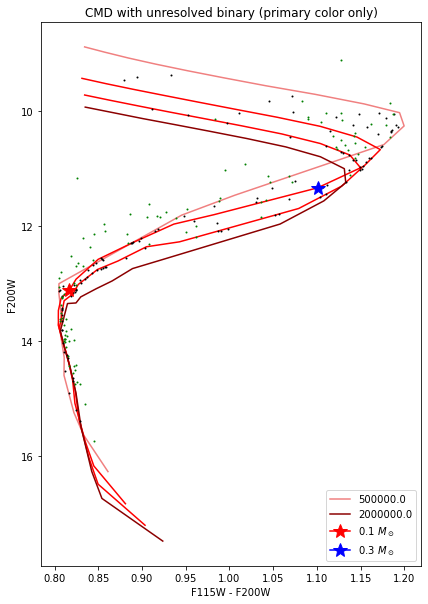

In [37]:
fig, axes = py.subplots(figsize=(15, 10))

py.subplot(1, 2, 1)

# CMD with unresolved binaries

for i in range(len(log_age_arr)):
    if i == 0:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(log_age_arr) - 1:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'red', label='')

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
            unresolved_binaries[i][1], marker='o', markersize=1, color='green')
    
idx_0p5 = np.where( abs(instances[1].points['mass'] - 0.1) == min(abs(instances[1].points['mass'] - 0.1)) )[0]
py.plot(instances[1].points[filters[0]][idx_0p5] - instances[1].points[filters[1]][idx_0p5],
       instances[1].points[filters[1]][idx_0p5], ms=15, marker='*', color='r', label='0.1 $M_\odot$')

idx_0p8 = np.where( abs(instances[1].points['mass'] - 0.3) == min(abs(instances[1].points['mass'] - 0.3)) )[0]
py.plot(instances[1].points[filters[0]][idx_0p8] - instances[1].points[filters[1]][idx_0p8],
       instances[1].points[filters[1]][idx_0p8], ms=15, marker='*', color='b', label='0.3 $M_\odot$')

py.xlabel('F115W - F200W')
py.ylabel('F200W')
py.gca().invert_yaxis()
py.title('CMD with unresolved binary (primary color only)')
py.legend()

In [40]:
# Bounding box range 
color_min = 0.85
color_max = 1.05
mag_min = 11
mag_max = 13
color_step = 0.05

mags = []
bin_std_deviations = []

# Iterate over color bins
for color_index in np.arange(color_min, color_max, color_step):
    mag_bin = []
    count = 0
    
    # Iterate over stars within the current color bin
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        if color_index < stars[i][3] - stars[i][4] < color_index + color_step and mag_min < stars[i][4] < mag_max:
            mag_bin.append(stars[i][4])
            count += 1

    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        if color_index < stars[i + first_binary][3] - stars[i + first_binary][4] < color_index + color_step and mag_min < unresolved_binaries[i][1] < mag_max:
            mag_bin.append(unresolved_binaries[i][1])
            count += 1

    bin_std = np.std(mag_bin)
    bin_std_deviations.append(bin_std)
    
    print(f"Standard deviation for color index {color_index:.2f} to {color_index + color_step:.2f}: {bin_std:.2f}")

# Compute the average standard deviation
average_std = np.mean(bin_std_deviations)
print("Average standard deviation:", average_std)

Standard deviation for color index 0.85 to 0.90: 0.27
Standard deviation for color index 0.90 to 0.95: 0.22
Standard deviation for color index 0.95 to 1.00: 0.32
Standard deviation for color index 1.00 to 1.05: 0.21
Standard deviation for color index 1.05 to 1.10: 0.28
Average standard deviation: 0.2604378204482827


In [39]:
# Retry spread calculation without binaries
# Bounding box range 
'''
color_min = 0.85
color_max = 1.05
mag_min = 11
mag_max = 14
color_step = 0.05

mags = []
bin_std_deviations = []

# Iterate over color bins
for color_index in np.arange(color_min, color_max, color_step):
    mag_bin = []
    count = 0
    
    # Iterate over stars within the current color bin
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        if color_index < stars[i][3] - stars[i][4] < color_index + color_step and mag_min < stars[i][4] < mag_max:
            mag_bin.append(stars[i][4])
            count += 1

    bin_std = np.std(mag_bin)
    bin_std_deviations.append(bin_std)
    
    print(f"Standard deviation for color index {color_index:.2f} to {color_index + color_step:.2f}: {bin_std:.2f}")

# Compute the average standard deviation
average_std = np.mean(bin_std_deviations)
print("Average standard deviation:", average_std)
'''

'\ncolor_min = 0.85\ncolor_max = 1.05\nmag_min = 11\nmag_max = 14\ncolor_step = 0.05\n\nmags = []\nbin_std_deviations = []\n\n# Iterate over color bins\nfor color_index in np.arange(color_min, color_max, color_step):\n    mag_bin = []\n    count = 0\n    \n    # Iterate over stars within the current color bin\n    for i in range(0, first_binary):\n        if stars[i] is None:\n            continue\n        if color_index < stars[i][3] - stars[i][4] < color_index + color_step and mag_min < stars[i][4] < mag_max:\n            mag_bin.append(stars[i][4])\n            count += 1\n\n    bin_std = np.std(mag_bin)\n    bin_std_deviations.append(bin_std)\n    \n    print(f"Standard deviation for color index {color_index:.2f} to {color_index + color_step:.2f}: {bin_std:.2f}")\n\n# Compute the average standard deviation\naverage_std = np.mean(bin_std_deviations)\nprint("Average standard deviation:", average_std)\n'